In [1]:
# Loading of all necessary imports
# Using Seaborn instead of matplotlib for most plots as it has more powerful plots out of the box
import pandas as pd
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import seaborn as sns
import numpy as np
from matplotlib import colors
from datetime import datetime 

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

In [56]:
sns.set_theme()

In [2]:
# Local source of data
data_path = "../data/"

daily_path = join(data_path, "processed", "daily_data.csv.gz")
dem_path = join(data_path, "processed", "participant_data.csv.gz")

In [3]:
df_participants = pd.read_csv(dem_path, compression='gzip')
df_daily = pd.read_csv(daily_path, compression='gzip')

In [4]:
df_participants.set_index("participant_id", inplace=True)
df_daily.set_index('participant_id', inplace=True)

In [5]:
# Joining all the different dataframes together using participant ID as the key 

df = df_daily.merge(df_participants, how="left", on='participant_id', suffixes=(None, '_dem'))
df.reset_index(inplace=True)

In [6]:
df['WearTime'] = (df['Cardio_minutes'] + df['Fat Burn_minutes'] + df['Peak_minutes'] + df['Out of Range_minutes'])
df = df[df['WearTime'] > 720]
df_g = df.groupby('participant_id').mean()
df_g['Count'] = df.groupby('participant_id')['NumberSteps'].count()
df = df_g
df = df[df['Count'] > 5]

C:\Users\bgrem\AppData\Local\Temp\ipykernel_21976\2791130181.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_g = df.groupby('participant_id').mean()


In [7]:
df.describe()

,Cardio_caloriesOut,Cardio_max,Cardio_min,Cardio_minutes,Fat Burn_caloriesOut,Fat Burn_max,Fat Burn_min,Fat Burn_minutes,NumberSteps,Out of Range_caloriesOut,...,randPhysical,randLimitPhysical,randLimitEmotional,randEnergyFatigue,randEmotion,randSocial,randPain,randGeneralHealth,WearTime,Count
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,...,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,203.000000,203.000000
mean,51.800981,153.811074,126.637544,7.076584,890.707219,126.637544,90.539828,286.293334,9576.551319,1290.259098,...,90.504794,90.609137,90.862944,57.664975,78.923858,82.170051,81.649746,74.397208,1198.756642,53.891626
std,103.243525,8.374239,6.932931,13.579481,563.485401,6.932931,4.927620,195.652361,2642.343507,546.940816,...,20.010247,23.897363,23.473579,18.397121,16.152945,22.127420,19.093130,17.451461,161.995980,17.772993
min,0.373298,130.238095,107.238095,0.067797,125.995994,107.238095,77.000000,27.971429,4394.255319,10.233513,...,0.000000,0.000000,0.000000,0.000000,16.000000,0.000000,22.500000,15.000000,795.000000,6.000000
25%,11.630808,148.000000,122.000000,1.567670,509.004919,122.000000,87.000000,137.389706,7556.865347,938.850604,...,95.000000,100.000000,100.000000,45.000000,72.000000,75.000000,67.500000,65.000000,1091.719298,40.500000
50%,27.461664,155.909091,128.000000,3.358209,775.187481,128.000000,91.909091,230.368421,9278.163636,1256.317721,...,100.000000,100.000000,100.000000,60.000000,84.000000,87.500000,90.000000,75.000000,1255.718750,60.000000
75%,51.802468,160.000000,132.000000,6.857537,1157.068605,132.000000,94.000000,406.279167,11005.193116,1551.437374,...,100.000000,100.000000,100.000000,70.000000,92.000000,100.000000,100.000000,85.000000,1325.534404,69.000000
max,1125.261285,171.000000,141.000000,124.709677,4252.168767,141.000000,101.000000,866.897059,17774.500000,3630.162292,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1407.619718,71.000000


<Axes: xlabel='swls', ylabel='Density'>

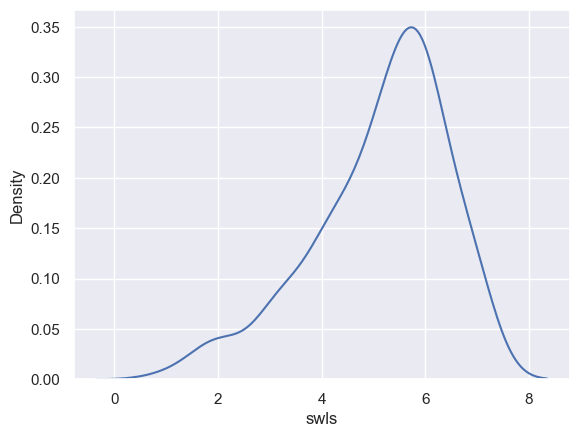

In [57]:
sns.kdeplot(x=df['swls'])

In [9]:
def regression_model(X, y, data):
    df_test = data[[*X, y]].copy().dropna()
    scaled = StandardScaler()
    df_test[X] = scaled.fit_transform(df_test[X])
    df_test['Intercept'] = 1


    model = sm.OLS(df_test[y], df_test[[*X, "Intercept"]])
    return model.fit()


In [36]:
df_tests = pd.read_csv('../tests.csv', delimiter=';')
adjusted_alpha = 0.05 / len(df_tests.index)
results  = [regression_model([row['Predictor']], row['Outcome'], df) for i, row in df_tests.iterrows()]
df_tests[['R-squared', 'P-value', 'JB-P-value', 'N', 'Coeff']] = [(result.rsquared, result.f_pvalue, statsmodels.stats.stattools.jarque_bera(result.resid)[1], int(len(result.resid)), result.params[0]) for result in results]
df_tests['Significant'] = df_tests['P-value'] < adjusted_alpha
df_tests['Normal Residuals'] = df_tests['JB-P-value'] > 0.05

In [37]:
df_tests

,Predictor,Outcome,X_text,Y_text,R-squared,P-value,JB-P-value,N,Coeff,Significant,Normal Residuals
0,NumberSteps,RestingHeartRate,the number of daily steps,resting heart rate,0.014939,8.234889e-02,1.643852e-01,203.0,-0.951524,False,True
1,Sleep1Efficiency,RestingHeartRate,the quality of sleep,resting heart rate,0.000093,8.922176e-01,1.390664e-01,200.0,0.074254,False,True
2,Cardio_minutes,RestingHeartRate,cardio exercise,resting heart rate,0.017526,5.971798e-02,5.312111e-01,203.0,1.030626,False,True
3,Peak_minutes,RestingHeartRate,high intensity exercise,resting heart rate,0.057141,5.931861e-04,1.184037e-01,203.0,-1.860926,True,True
4,Fat Burn_minutes,RestingHeartRate,fat burn exercise,resting heart rate,0.587980,1.455340e-40,1.306391e-09,203.0,5.969495,True,False
5,SleepMinutesAsleep,RestingHeartRate,sleep duration,resting heart rate,0.045132,2.342600e-03,8.802701e-01,203.0,-1.653859,True,True
6,audit,RestingHeartRate,alcohol usage,resting heart rate,0.010453,1.507295e-01,1.915170e-01,199.0,-0.796198,False,True
7,Cardio_minutes,psqi,cardio exercise,sleep quality,0.000080,8.994289e-01,2.015353e-06,201.0,0.021439,False,False
8,Peak_minutes,psqi,high intensity exercise,sleep quality,0.001732,5.574664e-01,4.455194e-06,201.0,-0.099470,False,False
9,stai,psqi,anxiety,sleep quality,0.066095,2.293780e-04,2.016318e-03,201.0,0.614462,True,False


In [38]:
with pd.option_context("max_colwidth", 1000):
    with pd.option_context("styler.latex.multirow_align", "t"):
        df_tex = df_tests.set_index(['Outcome', 'Predictor'])
        s = df_tex[["N", "R-squared", "P-value", "JB-P-value"]].style
        s = s.format_index(escape="latex", axis=0)
        s = s.format_index(escape="latex", axis=1)
        s = s.highlight_between(left=0, right=adjusted_alpha, subset='P-value',  props='bfseries: ;')
        s = s.highlight_between(left=0.05, right=1, subset='JB-P-value',  props='bfseries: ;')
        s = s.format({'N': int})
        
        #df.to_latex(columns=["Hypothesis", 'Predictor', 'Outcome'], index=False, column_format='p{3.5cm}|p{5cm}|l', buf='test.tex')
        print(s.to_latex(column_format='l|l|l|l|l|l', hrules=True, clines="skip-last;data"))

\begin{tabular}{l|l|l|l|l|l}
\toprule
 &  & N & R-squared & P-value & JB-P-value \\
Outcome & Predictor &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{RestingHeartRate} & NumberSteps & 203 & 0.014939 & 0.082349 & \bfseries 0.164385 \\
 & Sleep1Efficiency & 200 & 0.000093 & 0.892218 & \bfseries 0.139066 \\
 & Cardio\_minutes & 203 & 0.017526 & 0.059718 & \bfseries 0.531211 \\
 & Peak\_minutes & 203 & 0.057141 & \bfseries 0.000593 & \bfseries 0.118404 \\
 & Fat Burn\_minutes & 203 & 0.587980 & \bfseries 0.000000 & 0.000000 \\
 & SleepMinutesAsleep & 203 & 0.045132 & \bfseries 0.002343 & \bfseries 0.880270 \\
 & audit & 199 & 0.010453 & 0.150729 & \bfseries 0.191517 \\
\cline{1-6}
\multirow[t]{4}{*}{psqi} & Cardio\_minutes & 201 & 0.000080 & 0.899429 & 0.000002 \\
 & Peak\_minutes & 201 & 0.001732 & 0.557466 & 0.000004 \\
 & stai & 201 & 0.066095 & \bfseries 0.000229 & 0.002016 \\
 & Fat Burn\_minutes & 201 & 0.000063 & 0.911149 & 0.000002 \\
\cline{1-6}
\multirow[t]{4}{*}{swls} & Cardio\_min

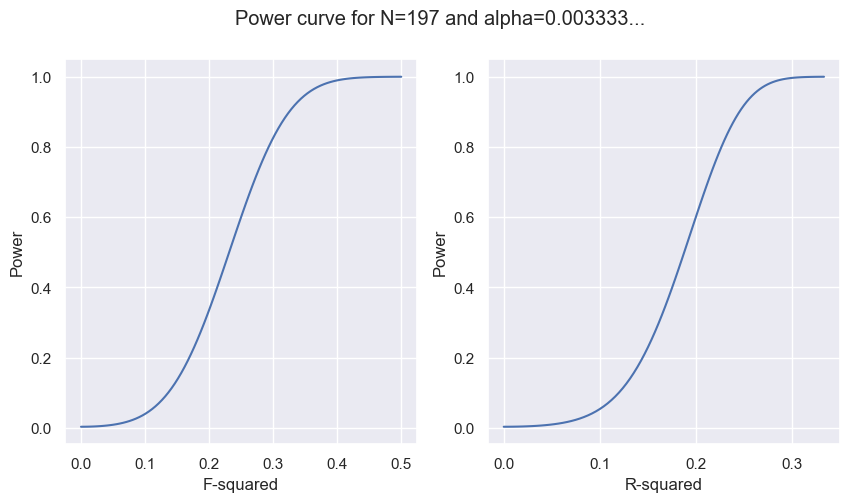

In [74]:
effectsf = list(np.linspace(0,0.5, num=100))
effectsr = [f/(1+f) for f in effectsf]
powers = [statsmodels.stats.power.FTestPower().power(effect_size=x, alpha=0.0033333333, df_num=197,
                                   df_denom=2) for x in effectsf]


fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Power curve for N=197 and alpha=0.003333...')
plot = sns.lineplot(ax=axs[0], y=powers, x=effectsf, legend='full')
plot.set(xlabel='F-squared', ylabel='Power')
plot = sns.lineplot(ax=axs[1], y=powers, x=effectsr, legend='full')
plot.set(xlabel='R-squared', ylabel='Power')
plt.show()
fig.savefig('../power_curves.jpg')

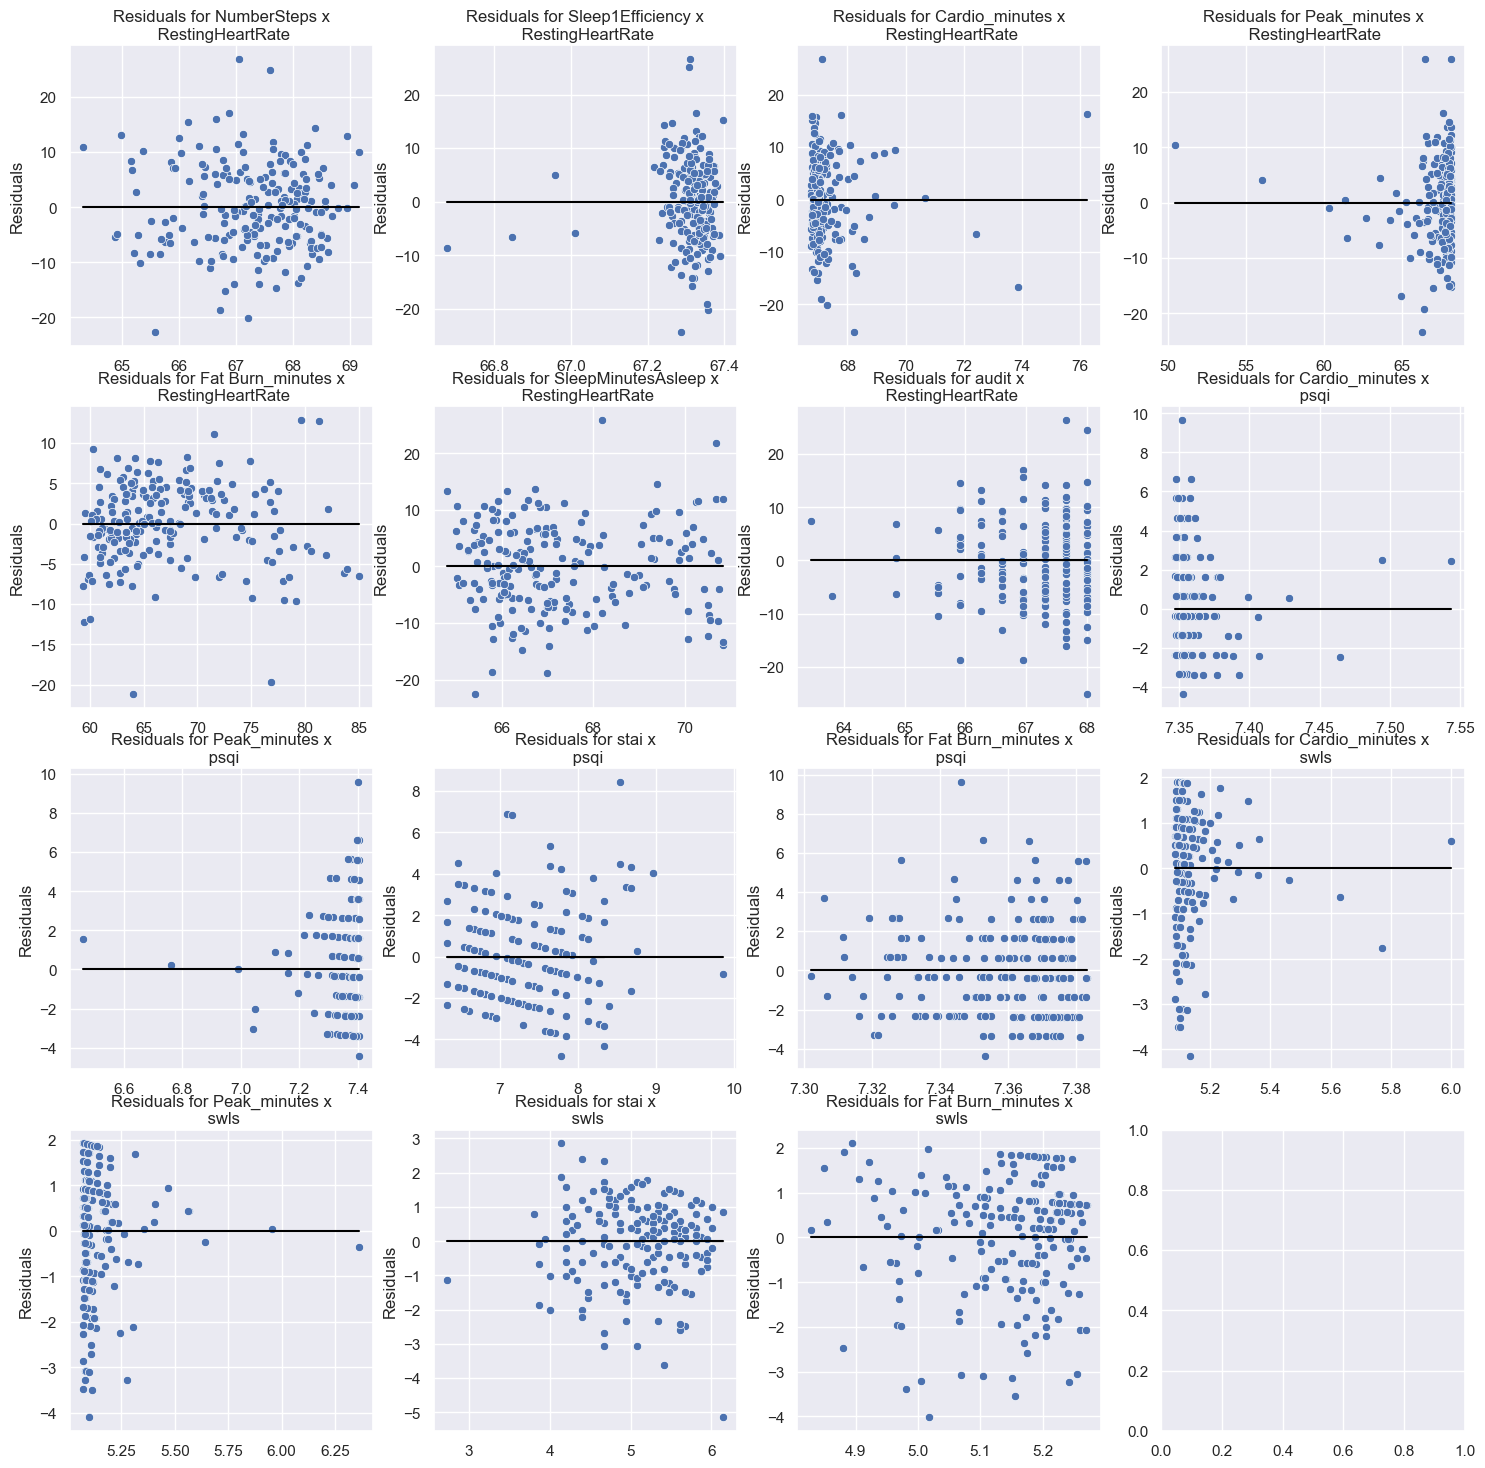

In [59]:
fig, axs = plt.subplots(4, 4, figsize=(18,18))
for i, result in enumerate(results):
    ax = axs[i//4][i%4]
    sns.scatterplot(ax=ax, y=result.resid, x=result.predict())
    sns.lineplot(ax=ax, y=0, x=result.predict(), color='black')
    ax.set_title(f'Residuals for {result.params.index[0]} x\n {result.model.endog_names}', wrap=True)
    ax.set(ylabel=f'Residuals')
fig.savefig('../residual_plot.jpg')

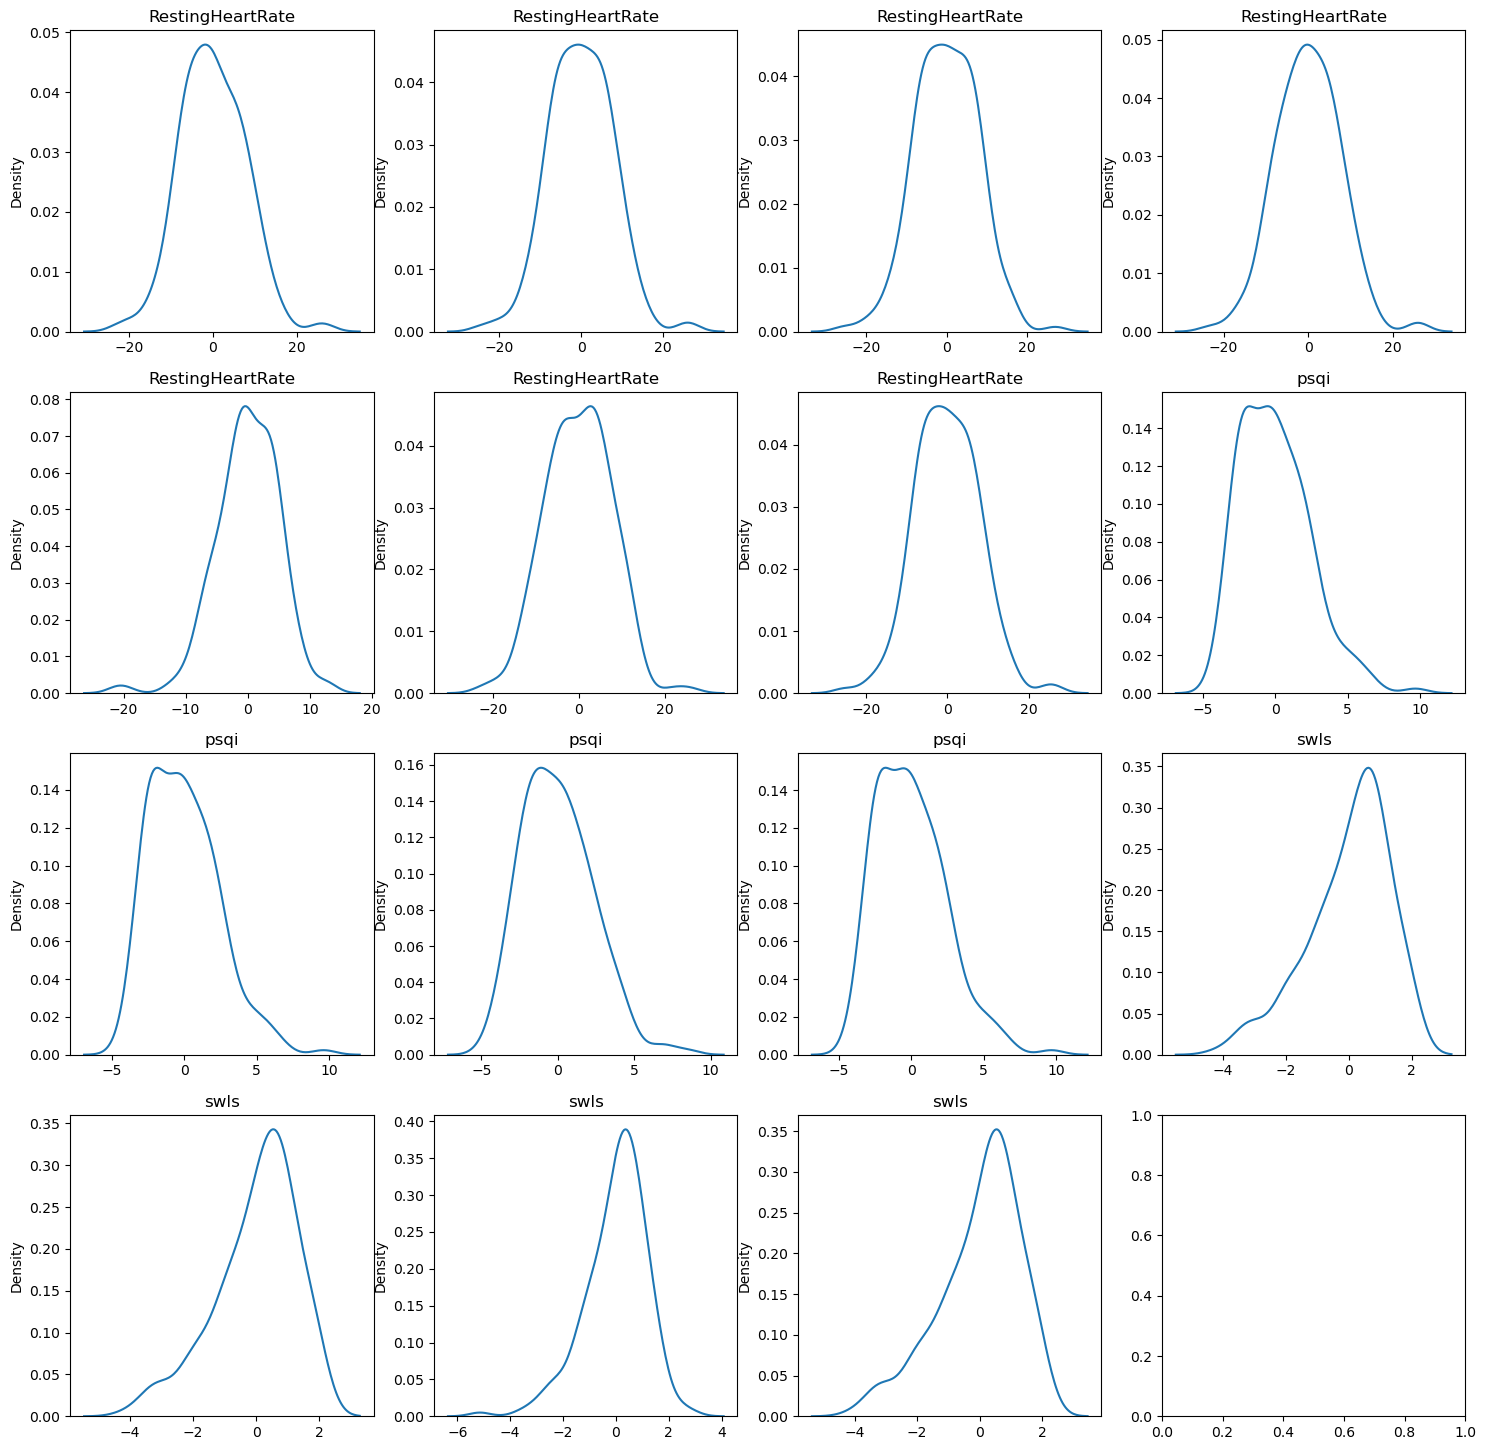

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(18,18))
for i, result in enumerate(results):
    ax = axs[i//4][i%4]
    sns.kdeplot(ax=ax, x=result.resid)
    ax.set_title(f'{result.model.endog_names}', wrap=True)

In [15]:
print(np.square(results.rsquared / (1 - results.rsquared)))

AttributeError: 'list' object has no attribute 'rsquared'

In [ ]:
sns.relplot(data=df_test, x='WearTime', y='RestingHeartRate')

In [ ]:
sns.relplot(data=df_reg, x='y_pred', y='res')

In [ ]:
sns.relplot(data=df_melt, x=X_cols[0], y='value', hue='variable')

In [ ]:
newdf = df.interpolate()
newdf.drop(['Sleep3MinutesStageDeep', 'Sleep3MinutesStageLight', 'Sleep3MinutesStageRem', 'Sleep3MinutesStageWake', 'englyrs', 'igtb_incomplete'], axis=1, inplace=True)
for col in newdf.columns:
    newdf[col] = newdf[col].interpolate()
newdf = newdf.groupby('participant_id').mean()
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = newdf.select_dtypes(include=numerics)
newdf.describe()
for col in newdf.columns:
    if np.isinf(newdf[col].values.sum()):
        print(col)
    if newdf[col].hasnans:
        print(col, 'nan')

In [ ]:
y = newdf['RestingHeartRate']
X = newdf.drop(['RestingHeartRate'], axis=1)
model = sm.GLS(endog=newdf['RestingHeartRate'], exog=X)
result = model.fit()
result.summary()

In [ ]:
mixed_df = df[['participant_id', 'RestingHeartRate', 'alc_Status', 'Fat']].copy()
mixed_df = pd.get_dummies(mixed_df, columns=['alc_Status'], drop_first=True)
mixed_df.dropna(inplace=True)
mixed_df = mixed_df.groupby('participant_id').mean()
X = mixed_df.drop(['RestingHeartRate'], axis=1)
X['Intercept'] = 1
y = mixed_df['RestingHeartRate']
#mixed_df['date'] = mixed_df['date'] .apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
#yesterday = mixed_df.copy()
#yesterday['date'] = yesterday['date']  + pd.Timedelta("-1 day")
#mixed_df = mixed_df.merge(yesterday, on=["date", "participant_id"], how="inner", suffixes=("_today", None))

model = sm.OLS(endog=y, exog=X)
result = model.fit()
result.summary()

In [ ]:
mixed_df['y_pred'] = result.predict()
mixed_df['res'] = mixed_df['y_pred'] - mixed_df['RestingHeartRate']
sns.relplot(data=mixed_df, x='y_pred', y='res')